In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
USERS_INFO_CSV = os.path.join(ROOT_DIR, 'output', '2022-02-03', 'user-objs.csv')
BASELINE_LOCATIONS_TXT = os.path.join(ROOT_DIR, 'input', 'locations.txt')

baseline_locations_df = pd.read_csv(BASELINE_LOCATIONS_TXT, sep='\n')
baseline_locations_df['locations'] = baseline_locations_df['locations'].map(str.strip)

df = pd.read_csv(USERS_INFO_CSV, dtype={
    'user_id': pd.Int64Dtype(),
    'screen_name': pd.StringDtype(),
    'location': pd.StringDtype(),
    'created_at': pd.StringDtype(),
    'name': pd.StringDtype(),
    'description': pd.StringDtype(),
    'statuses_count': pd.Int64Dtype(),
    'friends_count': pd.Int64Dtype(),
    'followers_count': pd.Int64Dtype(),
    'verified': bool,
    'protected': bool,
})


df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y') # 30s
df['location'] = df['location'].transform(lambda x: str(x).strip())
df['is_croatian'] = df['location'].transform(lambda x: x in baseline_locations_df['locations'].unique() 
                                                or 'croatia' in x.lower()
                                                or 'hrvatska' in x.lower())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788234 entries, 0 to 1788233
Data columns (total 12 columns):
 #   Column           Dtype              
---  ------           -----              
 0   user_id          Int64              
 1   location         object             
 2   screen_name      string             
 3   name             string             
 4   statuses_count   Int64              
 5   friends_count    Int64              
 6   followers_count  Int64              
 7   description      string             
 8   created_at       datetime64[ns, UTC]
 9   verified         bool               
 10  protected        bool               
 11  is_croatian      bool               
dtypes: Int64(4), bool(3), datetime64[ns, UTC](1), object(1), string(3)
memory usage: 134.7+ MB


In [25]:
import string
accepted_chars = string.ascii_lowercase + 'čšćžđ'

def transform_location1(location):
    location_names = ('hrvatska', 'croatia', 'republic of croatia', 'croatia')
    transformed_location = location.lower().strip()
    for name in location_names:
        if transformed_location == name:
            return 'Hrvatska'
        
        if name in location.lower():
            transformed_location = transformed_location.replace('hrvatska', '')
            transformed_location = transformed_location.replace('croatia', '')
            transformed_location = transformed_location.replace('republic of', '')
        
        for char in location.lower():
            if char not in accepted_chars and char != ' ':
                transformed_location = transformed_location.replace(char, '')
    return transformed_location.strip().title()

df['location1'] = df['location'].transform(transform_location1)

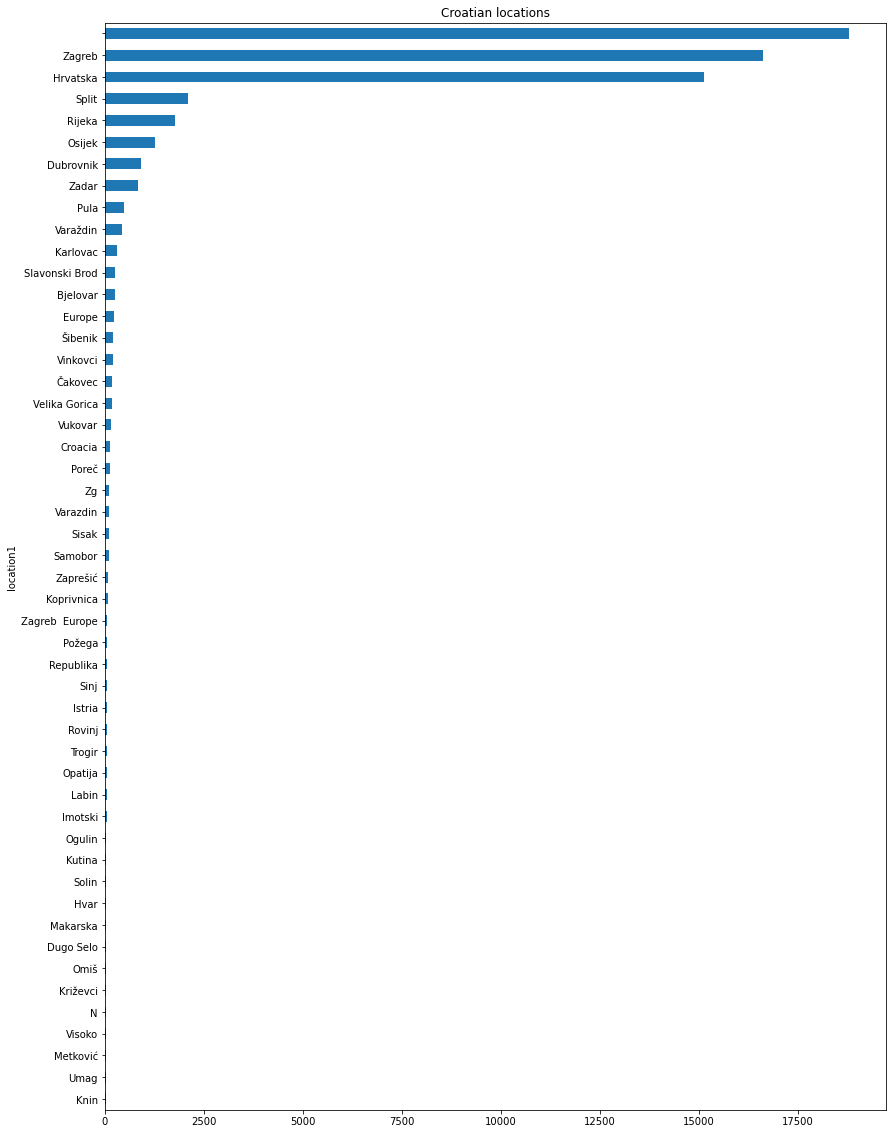

In [26]:
df[df['is_croatian'] == True].groupby('location1').size() \
 .sort_values(ascending=False).head(50) \
 .iloc[::-1].plot.barh(title='Croatian locations',figsize=(14, 20))
plt.show()

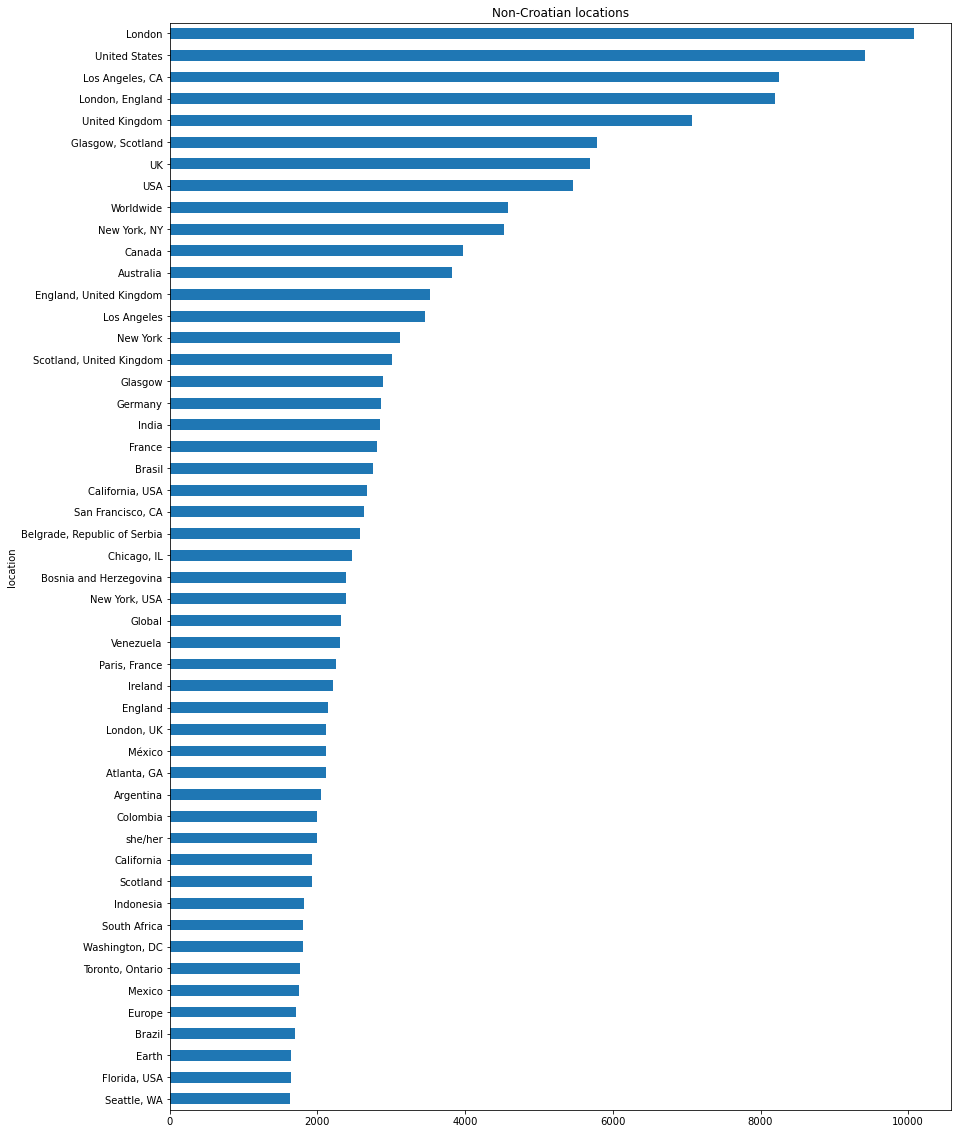

In [30]:
df[
    (df['is_croatian'] == False)
    & (df['location'] != '<NA>')
].groupby('location').size() \
 .sort_values(ascending=False).head(50) \
 .iloc[::-1].plot.barh(title='Non-Croatian locations',figsize=(14, 20))
plt.show()

In [31]:
len(df[df['is_croatian'] == True])

65526

56695

In [35]:
df = df.drop_duplicates('user_id')
df[
    (df['is_croatian'] == True)
    & (df['protected'] == False)
    & (df['friends_count'] > 10)
    & (df['followers_count'] > 10)
    & (df['followers_count'] < 5000)
    & (df['statuses_count'] > 10)
].sort_values(by='followers_count').to_csv('new_baseline_user_ids.csv', encoding='utf-8', index=False)

In [91]:
df.set_index('user_id').loc[306282269]

location                                     <NA>
screen_name                            scottmccan
name                                           ‎.
statuses_count                              51004
friends_count                                4023
followers_count                              3691
description                                  <NA>
created_at              2011-05-27 16:13:40+00:00
verified                                    False
protected                                   False
is_croatian                                 False
potentally_croatian                         False
potentially_croatian                        False
Name: 306282269, dtype: object

In [48]:
def output_baseline_ids():
    output_df = df[
        (df['is_croatian'] == True)
        & (df['protected'] == False)
        & (df['friends_count'] > 10)
        & (df['followers_count'] > 10)
        & (df['followers_count'] < 5000)
        & (df['statuses_count'] > 10)
    ].sort_values(by='followers_count')
    output_df.user_id.to_json('../../output/new_baseline-user-ids.json', orient='records')

output_baseline_ids()

In [49]:
df[df.user_id == 4134141929]

,user_id,location,screen_name,name,statuses_count,friends_count,followers_count,description,created_at,verified,protected,is_croatian,potentially_croatian,location1
1166171,4134141929,"Republic of Croatia, Split",codify_hr,Codify,22,107,11,<NA>,2015-11-07 12:33:57+00:00,False,False,True,False,Split
